## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import copy

from collections import defaultdict

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src import runner
from src import gen_spectra

# Correct sequence fall off detection
We have a property in the program that lets us pass in a "truth" set. This truth set we will pull from Delong lab and will primarily be used for debugging our hybrids. The steps we need to take:
1. Load in SpectrumMill results and create a "truth" set where each entry in this json file has the form:
```json
{
    spectrum_id: {
        "sequence": str, 
        "hybrid": bool, 
        "parent": str
    }
}
```
2. Run hyped search with the "truth_set" param set to the file generated in step 1
3. Load in the file created (output_dir + 'fall_off.json')
4. Run all analysis

## Constants

In [2]:
spec_file = '/Users/zacharymcgrath/Desktop/nod2 data/filteredSpec/'
db_file = '/Users/zacharymcgrath/Desktop/nod2 data/filteredNOD2.fasta'
output_dir = '/Users/zacharymcgrath/Desktop/Experiment output/fall_off/'
specmil_truth_set = '/Users/zacharymcgrath/Downloads/NOD2_E3_results.ssv'

minPep = 3
maxPep = 30
tolerance = 20
relative_abundance_filter = 0.0
precursor_tolerance = 10
peak_filter = 25
verbose = True


## 1. Load in SpectrumMill and create truth file

In [3]:
# first load in the results
specmil_results = pd.read_csv(specmil_truth_set, sep=';')
specmil_results.head(5)


,number,filename,parent_charge,score,deltaForwardReverseScore,deltaRank1Rank2Score,percent_scored_peak_intensity,totalIntensity,previous_aa,sequence,next_aa,retentionTimeMin,chromatographicPeakWidthSec,parent_m_over_z,species,entry_name
0,1,NOD2_E3.13446.13477.2,2,10.10,10.10,9.91,84.5,183000.0,(E),DPQVEQLEL,(-),48.35,26.0,535.7725,MOUSE,ins1C18
1,2,NOD2_E3.18005.18246.2,2,12.84,11.07,12.84,97.8,40000000.0,(G),DLQTLALEVA,(-),65.78,29.0,536.8007,MOUSE,ins1C3
2,3,NOD2_E3.13729.13828.2,2,12.43,6.68,7.86,90.7,2200000.0,(G),DLQTLALE,(-),49.52,22.0,451.7460,MOUSE,ins1C5
3,4,NOD2_E3.15226.15503.2,2,11.17,6.21,6.67,89.1,1740000.0,(G),DLQTLAL,(-),54.38,169.0,387.2243,MOUSE,ins1C6
4,5,NOD2_E3.21510.21510.2,2,12.54,12.54,12.54,91.3,91900.0,(G),DLQTLALLL,(D),76.92,3.0,500.3081,MOUSE,HYBRID: mouse ins1C PQVEQLELGGSPGDLQTLAL-LLDEG...


In [4]:
def get_hybrid_seq(peptide: str, protein: str) -> str:
    '''
    From a hybrid protein that looks like 
    ABCDE-FGHI
    
    and a peptide that looks like
    DEFGH
    
    extract 
    DE-FGH
    
    Inputs:
        peptide: (str) the desired subseq
        protein: (str) the full string with the hybrid character 
    Outputs:
        new peptide string
    '''
    # copy the protein
    prot_cp = copy.deepcopy(protein)
    
    # find the subseq
    peptide_idx = protein.replace('-', '').replace('(', '').replace(')', '').index(peptide)
    
    # get that stretch of prot
    add_on = len(peptide) + (1 if '-' in protein else 2)
    
    return protein[peptide_idx:peptide_idx+add_on]

In [5]:
# json to store results in
json_truth_set = {}

# go through every entry in the database, find out if its a hybrid and get the sequence, ided by the filename
for idx, row in specmil_results.iterrows():
    
    # all the ids seem to have .pkl at the end of them so add that
    key = row['filename'] + '.pkl'
    hybrid = 'HYBRID' in row['entry_name']
    
    seq = row['sequence'] if not hybrid else get_hybrid_seq(row['sequence'], row['entry_name'])
    
    json_truth_set[key] = {
        'hybrid': hybrid, 
        'sequence': seq, 
        'parent': row['entry_name']
    }
    
full_truth_path = output_dir + 'specmil_truth_set.json'
    
json.dump(json_truth_set, open(full_truth_path, 'w'))

## 2. Run hypedsearch with the truth set

In [6]:
truth_run_params = {
    'spectra_folder': spec_file,
    'database_file': db_file,
    'output_dir': output_dir,
    'min_peptide_len': minPep,
    'max_peptide_len': maxPep,
    'tolerance': tolerance,
    'precursor_tolerance': precursor_tolerance,
    'peak_filter': peak_filter, 
    'relative_abundance_filter': relative_abundance_filter,
    'digest': 'trypsin', 
    'missed_cleavages': 2,
    'verbose': verbose,
    'DEBUG': False,
    'cores': 16,
    'truth_set': full_truth_path
}

runner.run(truth_run_params)


DEV set to True. 
Tracking when correct answer falls off. 
Results are stored in a json named 'fall_off.json' in the specified output directory
File will be of the form

    {
        spectrum_id: {
            hybrid: bool, 
            truth_sequence: str, 
            fall_off_operation: str, 
        }
    }
            
Loading database...
Done
Loading spectra...
Done
On batch 1/1
On protein 280/280 [100%]
Sorting the set of protein masses...
Done
Initializing other processors...
Done.

Getting rid of NOD2_E3.3820.3820.5 in taking top n alignments

Creating an alignment for 1085/1086 [100%]
Finished search. Writting results to /Users/zacharymcgrath/Desktop/Experiment output/fall_off/...
Could not make an alignment for 351/1086 spectra (32%)


## 3. Load in the fall off results

In [7]:
fall_off_results = json.load(open(output_dir + 'fall_off.json'))
len(fall_off_results)

351

## 4. Run all analysis
### Plot the raw results

In [24]:
# first load them into dictionaries by {type: [seq]}
typed_fall_off = defaultdict(list)

for _id, entry in fall_off_results.items():
    typed_fall_off[entry['fall_off_operation']].append((_id, entry))
    

<BarContainer object of 5 artists>

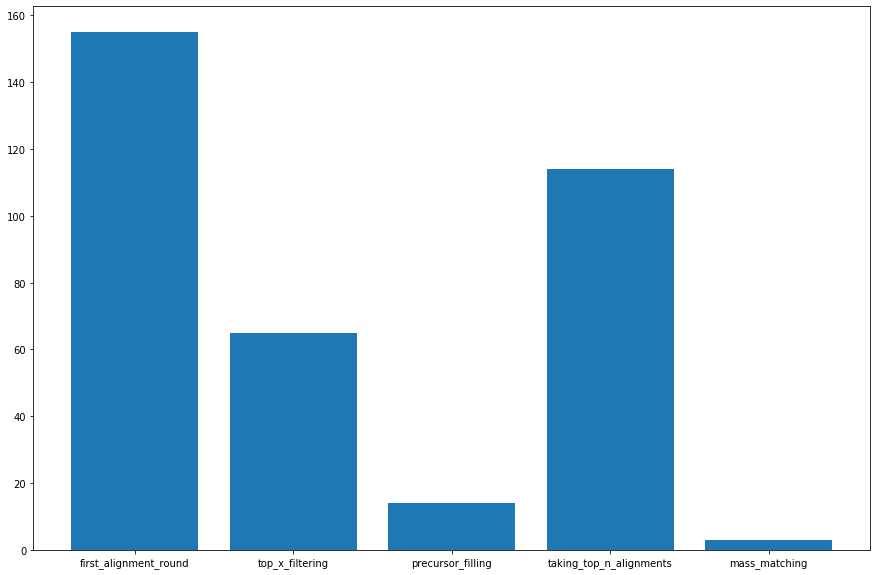

In [25]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)


### Just hybrid results

In [26]:
hybrid_typed_fall_off = defaultdict(list)
nonhybrid_typed_fall_off = defaultdict(list)

for _id, entry in fall_off_results.items():
    
    if entry['hybrid']:
        hybrid_typed_fall_off[entry['fall_off_operation']].append((_id, entry))
        
    else:
        nonhybrid_typed_fall_off[entry['fall_off_operation']].append((_id, entry))

Text(0.5, 1.0, 'Hybrid fall off positions')

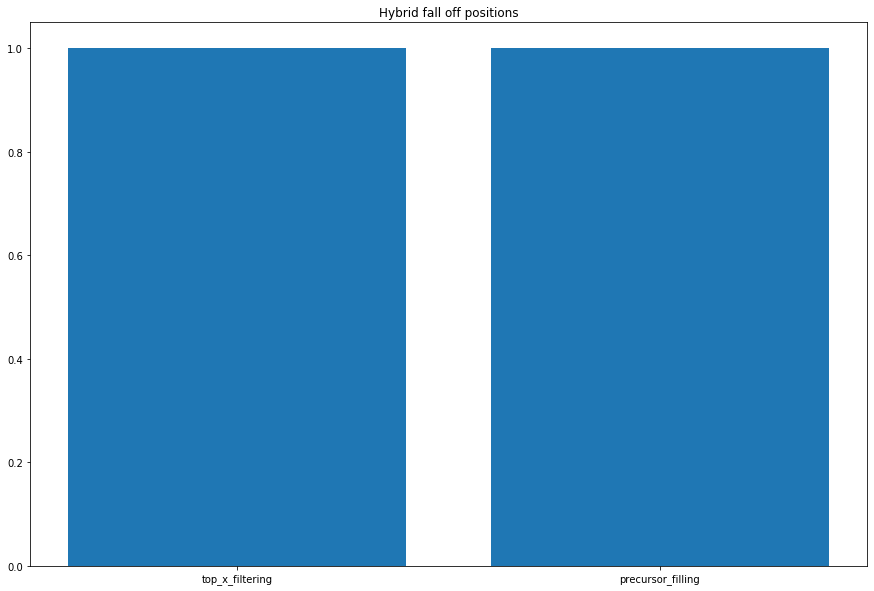

In [27]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(hybrid_typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)
plt.title('Hybrid fall off positions')

Text(0.5, 1.0, 'Non hybrid fall off positions')

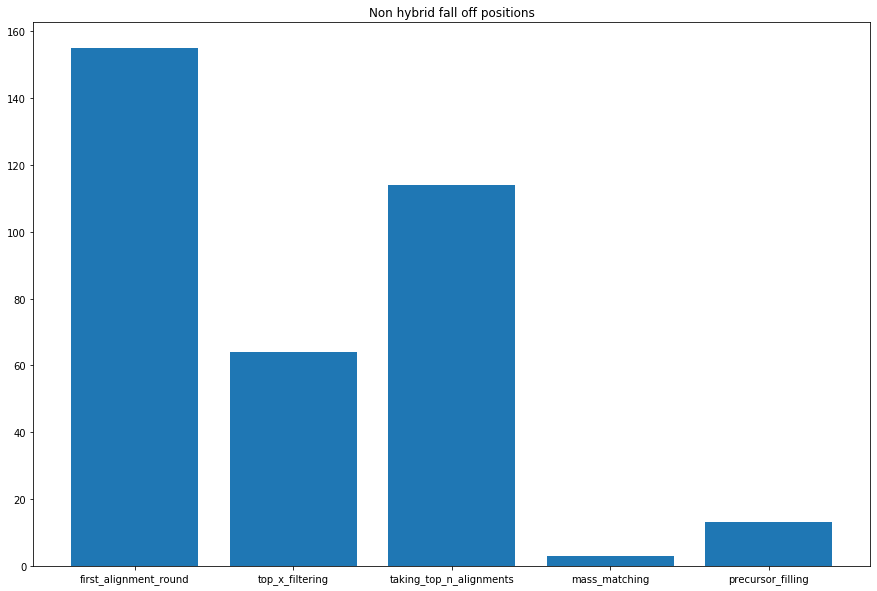

In [28]:
# bar graph it
plt.figure(figsize=(15, 10))

# get parallel x and y lists
x = []
y = []
xlabels = []

for i, (op, entries) in enumerate(nonhybrid_typed_fall_off.items()):
    x.append(i)
    y.append(len(entries))
    xlabels.append(op)
    
plt.bar(x, y, tick_label=xlabels)
plt.title('Non hybrid fall off positions')

### Hybrid analysis

In [29]:
precursor_fall_offs = [x for x in hybrid_typed_fall_off['precursor_filling']]

In [30]:
for pfo in precursor_fall_offs:
    t_seq = pfo[1]['truth_sequence']
        
    print(f'Truth sequence: {t_seq}')
    print('Before\n===========================================')
    for x in pfo[1]['meta_data']['sequences_before_precursor_filling']:
        if x[0][:2] == t_seq[:2] and x[0][-2:] == t_seq[-2:]:
            print(x)
            
    print('After\n===========================================')
    for x in pfo[1]['meta_data']['sequences_after_precursor_filling']:
        if x[0][:1] == t_seq[:1] and x[0][-1:] == t_seq[-1:]:
            print(x)
            
    print()

Truth sequence: DLQTL-EVE
Before
['DLQTLAEPEEVE', 'DLQT(L)AEPEEVE']
['DLQTLPQVE', 'DLQTL-PQVE']
['DLQTLINPVE', 'DLQTL-INPVE']
['DLQTLGAPVE', 'DLQTL-GAPVE']
['DLQTLPNVE', 'DLQTL-PNVE']
['DLQTLNPVE', 'DLQTL-NPVE']
['DLQTLHTLDVE', 'DLQTL-HTLDVE']
['DLQTLFRNTNVE', 'DLQTL-FRNTNVE']
After



In [31]:
top_x_filtering = [x for x in hybrid_typed_fall_off['top_x_filtering']]

In [32]:
def is_close(truth, tried, ion, close_dist=2):
    if len(tried) > len(truth):
        return False
    
    if ion == 'b':
        return truth[:close_dist].replace('I', 'B').replace('L', 'B') == tried[:close_dist].replace('I', 'B').replace('L', 'B')
    else:
        return truth[-close_dist:].replace('I', 'B').replace('L', 'B') == tried[-close_dist:].replace('I', 'B').replace('L', 'B')
    
for _id, txf in top_x_filtering:
    t_seq = txf['truth_sequence']
    
    print(f'Truth sequence: {t_seq}')
    
    print('Kept b hits close to correct half\n============================')
    for x in txf['meta_data']['top_x_b_hits']:
        if is_close(t_seq, x, 'b', 3):
            print(x)

    print('Kept y hits close to correct half\n============================')
    for x in txf['meta_data']['top_x_y_hits']:
        if is_close(t_seq, x, 'y', 3):
            print(x)
            
    print('Lost b hits close to correct half\n============================')
    for x in txf['meta_data']['excluded_b_hits']:
        if is_close(t_seq, x, 'b', 3):
            print(x)
            
    print('Lost y hits close to correct half\n============================')
    for x in txf['meta_data']['excluded_y_hits']:
        if is_close(t_seq, x, 'y', 3):
            print(x)
            
    print()

Truth sequence: DLQTLAL-NAAR
Kept b hits close to correct half
DLQT
DLQDQL
Kept y hits close to correct half
Lost b hits close to correct half
DLQ
DIQ
DLQI
DLQL
DIQI
DLQNL
DIQVK
DIQVKE
Lost y hits close to correct half
ESKKAARAAR
NAAR
AARAAR
RAALAAR
EGPRCEVAAR
LCLALAWAAR



### Non hybrid analysis
#### Precursor filling

In [33]:
# get the precursor filling subjects
nh_precursor_fall_off = [x for x in nonhybrid_typed_fall_off['precursor_filling']]

In [34]:
# go through every entry and find the sequences that were closest to the real sequence as possible
# closeness is: 
#   1. Having a lot of the right amino acids
#   2. Not have too many amino acids or too few
# Prioritize 1, rank by 2
def closeness(t_seq, trying, observed_precursor, observed_precursor_charge) -> (int, int):
    
    from_right = 0
    from_left = 0
    
    prec_distance = abs(gen_spectra.get_precursor(trying, observed_precursor_charge) - observed_precursor)
    
    # first check if they ARE the same
    if t_seq == trying:
        return (len(t_seq), 0, prec_distance)
    
    # go from left to right
    i = 0
    while i < len(t_seq) and i < len(trying) and t_seq[i] == trying[i]:
        i += 1
        from_left += 1
        
    # now right to left
    i = -1
    while abs(i) < len(t_seq) + 1 and abs(i) < len(trying) + 1 and t_seq[i] == trying[i]:
        i -= 1
        from_right += 1
        
    return (from_left + from_right, abs(len(t_seq) - len(trying)), prec_distance)

for _id, nhpfo in nh_precursor_fall_off:
    
    # get the real sequence
    t_seq = nhpfo['truth_sequence']
    
    # keep track of the best of the close ones 
    overlapped_idxed_close_hits = defaultdict(list)
    
    observed_prec = nhpfo['meta_data']['observed_precursor_mass']
    observed_prec_charge = nhpfo['meta_data']['observed_percursor_charge']
    
    for non_hyb, hyb in nhpfo['meta_data']['sequences_before_precursor_filling']:
        overlap, dist, prec_dist = closeness(t_seq, non_hyb, observed_prec, observed_prec_charge)
        overlapped_idxed_close_hits[overlap].append((non_hyb, hyb, dist, prec_dist))
        
    # now get the hightest key
    best_key = max(list(overlapped_idxed_close_hits.keys()))
    
    # show the best results sorted by their distance
    print(f'({_id}) Hits with the most overlap ({best_key} AAs) for sequence {t_seq} with allowed gap {nhpfo["meta_data"]["allowed_gap"]}')
    print('=====================================================================================')
    for seq, hyb_seq, dist, prec_distance in sorted(overlapped_idxed_close_hits[best_key], key=lambda x: x[2]):
        print(f'{seq} \t {dist} \t {prec_distance} \t {hyb_seq}')
        
    print()
    

(NOD2_E3.16717.16754.5.pkl) Hits with the most overlap (24 AAs) for sequence DGNGTIDFPEFLTMMARKMKDTDSEEEIR with allowed gap 11
IDFPEFLTMMARKMKDTDSEEEIR 	 5 	 88.83209105999993 	 None

(NOD2_E3.15783.15855.4.pkl) Hits with the most overlap (39 AAs) for sequence VEYPAHQAMNLVGPQSIEGGAHEGLQHLGPFGNIPNIVA with allowed gap 13
RVEYPAHQAMNLVGPQSIEGGAHEGLQHLGPFGNIPNIVA 	 1 	 39.02416607499981 	 None

(NOD2_E3.6565.6736.5.pkl) Hits with the most overlap (4 AAs) for sequence DFVQWLMNTKRNRNNIAKRH with allowed gap 8
DFVQTIPFVLSASLHG 	 4 	 162.08591806000004 	 DFV-QTIPFVLSASLHG
DFVQSQ 	 14 	 363.60199866 	 DFV-QSQ
DFVQNT 	 14 	 363.60199866 	 DFV-QNT
DFVQTN 	 14 	 363.60199866000005 	 DFV-QTN
DFVQQS 	 14 	 363.60199866 	 DFV-QQS

(NOD2_E3.13448.13448.2.pkl) Hits with the most overlap (12 AAs) for sequence DEDNTWEPEENL with allowed gap 5
SDEDNTWEPEENL 	 1 	 43.51597775000005 	 None

(NOD2_E3.18250.18282.6.pkl) Hits with the most overlap (41 AAs) for sequence DEWMRIILEALRQAENEPPSAPKENKPYALNLEKNFPVDTP w

#### Taking the top n alignments

In [35]:
top_n = nh_precursor_fall_off = [x for x in nonhybrid_typed_fall_off['taking_top_n_alignments']]

In [36]:
for _id, top_n_spec in top_n:
    t_seq = top_n_spec['truth_sequence']
    
    print(f'Top n alignments for sequence {t_seq}')
    print('============================================================')
    print('sequence \t b score \t y score \t total score \t precursor distance \t hybrid')
    print('------------------------------------------------------------')
    [print(f'{x["sequence"]} \t {x["b_score"]} \t {x["y_score"]} \t {x["total_score"]} \t {x["precursor_distance"]} \t {"hybrid_sequence" in x}') for x in top_n_spec['meta_data']['top_n']]
    
    print('------------------------------------------------------------')
    print('Missed alignments for this sequence')
    print('------------------------------------------------------------')
    [print(f'{x["sequence"]} \t {x["b_score"]} \t {x["y_score"]} \t {x["total_score"]} \t {x["precursor_distance"]} \t {"hybrid_sequence" in x}') for x in top_n_spec['meta_data']['not_top_n'][:10]]
    print('------------------------------------------------------------')
    all_alignments = [x for x in top_n_spec['meta_data']['top_n']] + [x for x in top_n_spec['meta_data']['not_top_n']]
    num_hyb = len([0 for x in all_alignments if 'hybrid_sequence' in x])
    p_hyb = int(100 * (float(num_hyb) / float(len(all_alignments))))
    scores = [x['total_score'] for x in all_alignments]
    avg_score = np.mean(scores)
    min_score = min(scores)
    
    print(f'Stats: \t Number alignments: {len(all_alignments)} \t % hybrid: {p_hyb} \t Average score: {avg_score} \t min score: {min_score}')
    print()

Top n alignments for sequence EVRKALSRQEMQEVQSSRSGRGGNFGFG
sequence 	 b score 	 y score 	 total score 	 precursor distance 	 hybrid
------------------------------------------------------------
ACRNLFGPVNHEGHRAVPAASYGRIYAGGG 	 3 	 3 	 4.5 	 0.0002288600001065788 	 True
ACRNLFGPVNWITLCIGEYSLIVNTATE 	 3 	 3 	 4.5 	 0.0037677399998301553 	 True
PPSYITQPEDPLGHRAVPAASYGRIYAGGG 	 3 	 3 	 4.5 	 0.00385833999996521 	 True
ACRNLFGPVNDAIYKEFSFKNFNQAFG 	 3 	 3 	 4.5 	 0.0061630600000626146 	 True
LPLDTDKGVHYISVSAATSEEQIKEYFG 	 2 	 4 	 4.5 	 0.001345540000102119 	 True
------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
LEGQCNPDLRLLGVARYNSYQSFQTPQ 	 2 	 3 	 4.5 	 0.002743060000057085 	 True
SWCRAATLGHRAVPANRGGCEQRCLNTLG 	 2 	 3 	 4.5 	 0.003907260000119095 	 True
EEVRKNKESKDPANMIEVHKDTDLSKG 	 2 	 2 	 4 	 0.005711539999765591 	 False
EVRKALSRQEMQEVQSSRSGRGGNFGFG 	 0 	 4 	 4 	 0.00094893999983014

------------------------------------------------------------
Missed alignments for this sequence
------------------------------------------------------------
KKVRNNNADAEDKYVANTV 	 3 	 2 	 5 	 0.004599924999979521 	 False
KDKDANGLVHYNIDHIPIS 	 4 	 2 	 5.0 	 0.0035941749999892636 	 True
PESKVFYLKMKGDYFPTV 	 3 	 3 	 4.5 	 0.003550174999986666 	 True
PESKVFYLKMKGDYIMTV 	 2 	 2 	 4 	 0.0027074250000396205 	 False
DKGSSKEVEHAKIPEPTPTV 	 1 	 3 	 4 	 0.0011176749999322055 	 False
KKVRNNNADAEDPVPGKPTV 	 4 	 3 	 4.0 	 0.004498825000041506 	 True
KMTQIGFTEVQLSSVSPPSL 	 3 	 3 	 4.0 	 0.0007308250002324712 	 True
KKPVSEDIPGPLQGSGQDPTV 	 3 	 3 	 4.0 	 0.0011174249999612584 	 True
KKHGTKNSAMTQNPRPGSPL 	 3 	 3 	 4.0 	 0.0028678250000666594 	 True
KTMQALEKAGYILTGNNPLS 	 3 	 3 	 4.0 	 0.0035370750000538465 	 True
------------------------------------------------------------
Stats: 	 Number alignments: 96 	 % hybrid: 90 	 Average score: 3.4270833333333335 	 min score: 1

Top n alignments for sequence DFFS

#### first alignment round

In [37]:
first_as = [x for x in nonhybrid_typed_fall_off['first_alignment_round']]

In [38]:
def most_aa_overlap(truth, trying):
    overlap = 0
    
    if truth == trying:
        return len(truth)
    
    i = 0
    while i < len(truth) and i < len(trying) and trying[i] == truth[i]:
        i += 1
        overlap += 1
        
    i = -1
    while i > -1 * min(len(trying), len(truth)) and truth[i] == trying[i]:
        i -= 1
        overlap += 1
        
    return overlap - max(0, len(trying) - len(truth))

for _id, fa in first_as:
    
    t_seq = fa['truth_sequence']
    
    most_overlap = defaultdict(list)
    for non_hyb, hyb in fa['meta_data']['alignments']:
        most_overlap[most_aa_overlap(t_seq, non_hyb)].append((non_hyb, hyb))
        
    most_aas = max(list(most_overlap.keys()))
    closest_matches = most_overlap[most_aas]
    
    
    print(f'({_id}) Closest alignments to sequence {t_seq} at overlap {most_aas}')
    print('=================================================================')
    [print(f'{non_hyb} \t {hyb}') for non_hyb, hyb in closest_matches]
    print()
    

(NOD2_E3.13446.13477.2.pkl) Closest alignments to sequence DPQVEQLEL at overlap 6
DPQVEQLHICL 	 DPQVEQL-HICL
DPQVEQFSCL 	 DPQVEQ-FSCL
DPQVEQLSFCL 	 DPQVEQL-SFCL
DPQVEQLEHICL 	 DPQVEQLE-HICL
DPQVEFSCL 	 DPQVE-FSCL
DPQVEQLELTCI 	 DPQVEQLE-LTCI
DPQVEQLTCI 	 DPQVEQ(L)TCI
DPQVEHICL 	 DPQVE-HICL
DPQVEQLEAYCL 	 DPQVEQLE-AYCL
DPQVEQLEFSCL 	 DPQVEQLE-FSCL
DPQVEQAYCL 	 DPQVEQ-AYCL
DPQVEQLTCI 	 DPQVEQ-LTCI
DPQVENNPEL 	 DPQVE-NNPEL
DPQVESFCL 	 DPQVE-SFCL
DPQVEQLNNPEL 	 DPQVEQL-NNPEL
DPQVEQNNPEL 	 DPQVEQ-NNPEL
DPQVEQLAYCL 	 DPQVEQL-AYCL
DPQVEAYCL 	 DPQVE-AYCL
DPQVEQHICL 	 DPQVEQ-HICL
DPQVEQSFCL 	 DPQVEQ-SFCL
DPQVEQLFSCL 	 DPQVEQL-FSCL
DPQVEQLENNPEL 	 DPQVEQLE-NNPEL
DPQVEQLESFCL 	 DPQVEQLE-SFCL

(NOD2_E3.15226.15503.2.pkl) Closest alignments to sequence DLQTLAL at overlap 5
DLQTLFWAL 	 DLQT-LFWAL
DLQTLALFWAL 	 DLQTLA-LFWAL
DLQTLAPTAL 	 DLQTLA-PTAL
DLQTPTAL 	 DLQT-PTAL

(NOD2_E3.18005.18246.2.pkl) Closest alignments to sequence DLQTLALEVA at overlap 7
DLQTLDPGVA 	 DLQTL-DPGVA
DLQTLALDPGVA 	 DLQTLAL-D

(NOD2_E3.20059.20059.2.pkl) Closest alignments to sequence NWLIQTKITD at overlap 8
INWLIQTKITD 	 None

(NOD2_E3.13169.13169.3.pkl) Closest alignments to sequence DFPEEVAIAEELGRR at overlap 13
PEPEEVAIAEELGRR 	 PEP(E)EVAIAEELGRR
EPPEEVAIAEELGRR 	 EPP(E)EVAIAEELGRR
EPPEEVAIAEELGRR 	 EP(PE)EVAIAEELGRR
PEPEEVAIAEELGRR 	 PE(PE)EVAIAEELGRR
RDFPEEVAIAEELGRR 	 None

(NOD2_E3.15522.15522.3.pkl) Closest alignments to sequence DVSSYLEGQAAKEFIAWLVKGRGRR at overlap 5
DVSLTAFVLKMEVQRR 	 DVSLTAFVL-KMEVQRR
DVSMAAQITRR 	 DVS-MAAQITRR
DVSTAEKMEVQRR 	 DVSTAE-KMEVQRR
DVSTAEDIKFSTRR 	 DVSTAE-DIKFSTRR
DVSLTAFVLMAAQITRR 	 DVSLTAFVL-MAAQITRR
DVSLTAFVLDIKFSTRR 	 DVSLTAFVL-DIKFSTRR
DVSTAEMAAQITRR 	 DVSTAE-MAAQITRR
DVSSTDCWWNR 	 DVS-STDCWWNR
DVSKMEVQRR 	 DVS-KMEVQRR
DVSDIKFSTRR 	 DVS-DIKFSTRR

(NOD2_E3.4689.4689.3.pkl) Closest alignments to sequence QDTEENPRSFPASQTEAHEDP at overlap 19
QDTEPRSFPASQTEAHEDP 	 QDTE-PRSFPASQTEAHEDP
LQDTEENPRSFPASQTEAHEDP 	 None

(NOD2_E3.17301.17360.4.pkl) Closest alignments to seque

(NOD2_E3.3867.3867.4.pkl) Closest alignments to sequence EALRQAENEPPSAPKENKPY at overlap 18
LEALRQAENEPPSAPKENKPY 	 None

(NOD2_E3.9310.9393.4.pkl) Closest alignments to sequence EALRQAENEPPSAPKENKPYALNLEKNFPVDTP at overlap 31
LEALRQAENEPPSAPKENKPYALNLEKNFPVDTP 	 None

(NOD2_E3.6499.6499.4.pkl) Closest alignments to sequence EQAIKEHLGPGSSQEMERLAKVS at overlap 20
QLEQAIKEHLGPGSSQEMERLAKVS 	 None

(NOD2_E3.14323.14323.5.pkl) Closest alignments to sequence DDLQEEEQLEQAIKEHLGPGSSQEMERLAKVS at overlap 4
DDLGNAKSHLMSLYSESTRRMLQLVEES 	 DDLGNAKSHLMSLYS-ESTRRMLQLVEES
DDLPELYAELRAKCTPS 	 DDL-PELYAELRAKCTPS
DDLGNAKSHLMSLYSETLGSVPS 	 DDLGNAKSHLMSLYS-ETLGSVPS
DDLGNAKSHLMSLYSPELYAELRAKCTPS 	 DDLGNAKSHLMSLYS-PELYAELRAKCTPS
DDLGNAKSHLMSLYSEGKSPSPS 	 DDLGNAKSHLMSLYS-EGKSPSPS
DDLGNAKSHLMSLYSGHRRSFAERYDPS 	 DDLGNAKSHLMSLYS-GHRRSFAERYDPS
DDLQMEEKPVPAAPVPSP 	 DDL-QMEEKPVPAAPVPSP
DDLESTRRMLQLVEES 	 DDL-ESTRRMLQLVEES
DDLQDTYEITPLMRPL 	 DDL-QDTYEITPLMRPL
DDLEGKSPSPS 	 DDL-EGKSPSPS
DDLGNAKSHLMSLYSPSPSYRFQGILPS

(NOD2_E3.18536.18572.5.pkl) Closest alignments to sequence DETPDVDPELLRYLLGRILTGSSEPEAAPAPRRL at overlap 4
DETPAEEKK 	 DET-PAEEKK

(NOD2_E3.18032.18032.4.pkl) Closest alignments to sequence DVDPELLRYLLGRILTGSSEPEAAPAPRRL at overlap 28
PDVDPELLRYLLGRILTGSSEPEAAPAPRRL 	 None

(NOD2_E3.19284.19421.4.pkl) Closest alignments to sequence DVDPELLRYLLGRILTGSSEPEAAPAPR at overlap 25
TPDVDPELLRYLLGRILTGSSEPEAAPAPR 	 None

(NOD2_E3.18060.18100.6.pkl) Closest alignments to sequence DVDPELLRYLLGRILTGSSEPEAAPAPRRL at overlap 28
PDVDPELLRYLLGRILTGSSEPEAAPAPRRL 	 None

(NOD2_E3.13796.13796.3.pkl) Closest alignments to sequence DLQNLAPGTHPPFITFNSEVKT at overlap 20
ADLQNLAPGTHPPFITFNSEVKT 	 None

(NOD2_E3.14580.14580.2.pkl) Closest alignments to sequence EQKIGQPTLLLYV at overlap 10
EQKIGQPTLLLYVPPL 	 EQKIGQPTLLLY-VPPL
EQKIGQPTLLLYVPPI 	 EQKIGQPTLLLY-VPPI
EQKIGQPTLLLYVPIP 	 EQKIGQPTLLLY-VPIP
EQKIGQPTLLLYVPLP 	 EQKIGQPTLLLY-VPLP

(NOD2_E3.6296.6296.4.pkl) Closest alignments to sequence DAGAETMTQRLLKRGETSG